In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00


In [68]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

In [23]:
# Load the PPI dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [132]:
class PPIModel(nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
      super(PPIModel, self).__init__()
      self.conv1 = GCNConv(input_channels, hidden_channels)
      self.relu1 = nn.ReLU()
      self.dropout1 = nn.Dropout(0.5)
      self.conv2 = GCNConv(hidden_channels, hidden_channels)
      self.relu2 = nn.ReLU()
      self.dropout2 = nn.Dropout(0.4)
      self.linear = nn.Linear(hidden_channels, output_channels)

  def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = self.relu1(x)
      x = self.dropout1(x)
      x = self.conv2(x, edge_index)
      x = self.relu2(x)
      x = self.dropout2(x)
      x = self.linear(x)
      return x

In [133]:
ppi_model = PPIModel(input_channels=train_dataset.num_features, hidden_channels=64, output_channels=train_dataset.num_classes)
optim = torch.optim.Adam(ppi_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [134]:
def train(model, loader, optim, criterion):
    model.train()
    total_loss = 0
    for data in loader:
      optim.zero_grad()
      out = model(data)
      loss = criterion(out, data.y)
      loss.backward()
      optim.step()
      total_loss += loss.item()
    return total_loss/len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
      for data in loader:
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
    return total_loss/len(loader)

In [135]:
train_losses = []
val_losses = []
for epoch in range(300):
  train_loss = train(ppi_model, train_loader, optim, criterion)
  val_loss = evaluate(ppi_model, val_loader, criterion)

  if epoch % 10 == 0:
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  train_losses.append(train_loss)
  val_losses.append(val_loss)

Epoch 1, Train Loss: 0.6301, Val Loss: 0.5666
Epoch 11, Train Loss: 0.5057, Val Loss: 0.4878
Epoch 21, Train Loss: 0.4969, Val Loss: 0.4776
Epoch 31, Train Loss: 0.4904, Val Loss: 0.4713
Epoch 41, Train Loss: 0.4869, Val Loss: 0.4656
Epoch 51, Train Loss: 0.4865, Val Loss: 0.4658
Epoch 61, Train Loss: 0.4805, Val Loss: 0.4612
Epoch 71, Train Loss: 0.4825, Val Loss: 0.4602
Epoch 81, Train Loss: 0.4787, Val Loss: 0.4582
Epoch 91, Train Loss: 0.4789, Val Loss: 0.4575
Epoch 101, Train Loss: 0.4783, Val Loss: 0.4570
Epoch 111, Train Loss: 0.4766, Val Loss: 0.4559
Epoch 121, Train Loss: 0.4747, Val Loss: 0.4549
Epoch 131, Train Loss: 0.4763, Val Loss: 0.4535
Epoch 141, Train Loss: 0.4749, Val Loss: 0.4529
Epoch 151, Train Loss: 0.4740, Val Loss: 0.4525
Epoch 161, Train Loss: 0.4735, Val Loss: 0.4500
Epoch 171, Train Loss: 0.4730, Val Loss: 0.4513
Epoch 181, Train Loss: 0.4728, Val Loss: 0.4505
Epoch 191, Train Loss: 0.4727, Val Loss: 0.4508
Epoch 201, Train Loss: 0.4731, Val Loss: 0.4503
Epo

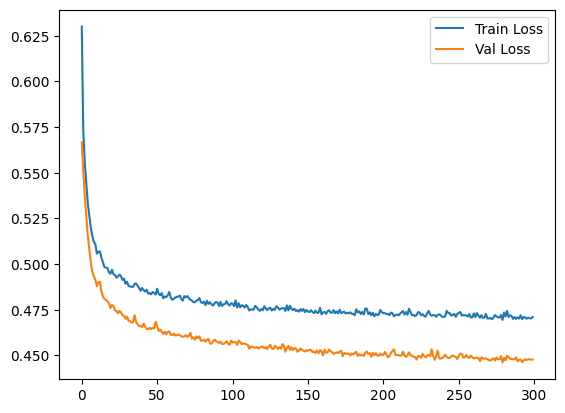

In [136]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [137]:
def predicted(model, loader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in loader:
      out = model(data)
      pred = (out > 0).float()
      correct += pred.eq(data.y).sum().item()
      total += data.y.numel()
  return correct/total, pred

In [138]:
test_acc, predictions = predicted(ppi_model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7959
